## Import neccessary Libraries

In [ ]:
pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=ae0708407ef98d7ed7eeba071e752a7ae66804d71f31e08c8b5467716c34469c
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.optim as optim
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader
import torch
from pathlib import Path
import multiprocessing
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# import sys
# sys.path.append('/usr/local/lib/python2.7/site-packages')

import cv2
import csv
from efficientnet_pytorch import EfficientNet

import random
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab/Emmen_28.xlsx')
data

,cameraRight,hereCurvature,canSteering,canSpeed
0,Emmen/go_pro_1/image/28/img00001.jpg,0.000000,-8.0,13.714433
1,Emmen/go_pro_1/image/28/img00002.jpg,0.000000,-8.0,13.735335
2,Emmen/go_pro_1/image/28/img00003.jpg,0.000000,-8.0,13.752301
3,Emmen/go_pro_1/image/28/img00004.jpg,0.000000,-8.0,13.737254
4,Emmen/go_pro_1/image/28/img00005.jpg,0.000000,-8.0,13.724012
...,...,...,...,...
2992,Emmen/go_pro_1/image/28/img02993.jpg,0.001578,-4.0,20.419199
2993,Emmen/go_pro_1/image/28/img02994.jpg,0.001516,-4.0,20.413135
2994,Emmen/go_pro_1/image/28/img02995.jpg,0.001456,-4.0,20.380975
2995,Emmen/go_pro_1/image/28/img02996.jpg,0.001395,-4.0,20.372512


In [ ]:
data = data[['cameraRight', 'canSpeed']]
data

,cameraRight,canSpeed
0,Emmen/go_pro_1/image/28/img00001.jpg,13.714433
1,Emmen/go_pro_1/image/28/img00002.jpg,13.735335
2,Emmen/go_pro_1/image/28/img00003.jpg,13.752301
3,Emmen/go_pro_1/image/28/img00004.jpg,13.737254
4,Emmen/go_pro_1/image/28/img00005.jpg,13.724012
...,...,...
2992,Emmen/go_pro_1/image/28/img02993.jpg,20.419199
2993,Emmen/go_pro_1/image/28/img02994.jpg,20.413135
2994,Emmen/go_pro_1/image/28/img02995.jpg,20.380975
2995,Emmen/go_pro_1/image/28/img02996.jpg,20.372512


### Normalizing Data

In [ ]:
# mormalize the canSpeed column
scaler = MinMaxScaler()
speed = np.array(data['canSpeed'])
speedNorm = scaler.fit_transform(speed.reshape(-1, 1))
speedNorm = speedNorm.flatten()
data['canSpeedNorm'] = speedNorm
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cameraRight,canSpeed,canSpeedNorm
0,Emmen/go_pro_1/image/28/img00001.jpg,13.714433,0.628432
1,Emmen/go_pro_1/image/28/img00002.jpg,13.735335,0.629391
2,Emmen/go_pro_1/image/28/img00003.jpg,13.752301,0.630170
3,Emmen/go_pro_1/image/28/img00004.jpg,13.737254,0.629479
4,Emmen/go_pro_1/image/28/img00005.jpg,13.724012,0.628872
...,...,...,...
2992,Emmen/go_pro_1/image/28/img02993.jpg,20.419199,0.936140
2993,Emmen/go_pro_1/image/28/img02994.jpg,20.413135,0.935862
2994,Emmen/go_pro_1/image/28/img02995.jpg,20.380975,0.934386
2995,Emmen/go_pro_1/image/28/img02996.jpg,20.372512,0.933997


In [ ]:
data['image_path'] = data['cameraRight'].apply(lambda x: '/content/drive/MyDrive/Colab/emmen_28_images/images'+'/'+str(x[-12:]))

In [ ]:
data

,cameraRight,canSpeed,canSpeedNorm,image_path
0,Emmen/go_pro_1/image/28/img00001.jpg,13.714433,0.628432,/content/drive/MyDrive/Colab/emmen_28_images/i...
1,Emmen/go_pro_1/image/28/img00002.jpg,13.735335,0.629391,/content/drive/MyDrive/Colab/emmen_28_images/i...
2,Emmen/go_pro_1/image/28/img00003.jpg,13.752301,0.630170,/content/drive/MyDrive/Colab/emmen_28_images/i...
3,Emmen/go_pro_1/image/28/img00004.jpg,13.737254,0.629479,/content/drive/MyDrive/Colab/emmen_28_images/i...
4,Emmen/go_pro_1/image/28/img00005.jpg,13.724012,0.628872,/content/drive/MyDrive/Colab/emmen_28_images/i...
...,...,...,...,...
2992,Emmen/go_pro_1/image/28/img02993.jpg,20.419199,0.936140,/content/drive/MyDrive/Colab/emmen_28_images/i...
2993,Emmen/go_pro_1/image/28/img02994.jpg,20.413135,0.935862,/content/drive/MyDrive/Colab/emmen_28_images/i...
2994,Emmen/go_pro_1/image/28/img02995.jpg,20.380975,0.934386,/content/drive/MyDrive/Colab/emmen_28_images/i...
2995,Emmen/go_pro_1/image/28/img02996.jpg,20.372512,0.933997,/content/drive/MyDrive/Colab/emmen_28_images/i...


In [ ]:
np.random.seed(42)
msk = np.random.rand(len(data)) < 0.8

train_df = data[msk].reset_index()
val_df = data[~msk].reset_index()

# old_data = data[msk].reset_index()
# new_data = data[~msk].reset_index()

In [ ]:
print(len(train_df))
print(len(val_df))

2390
607


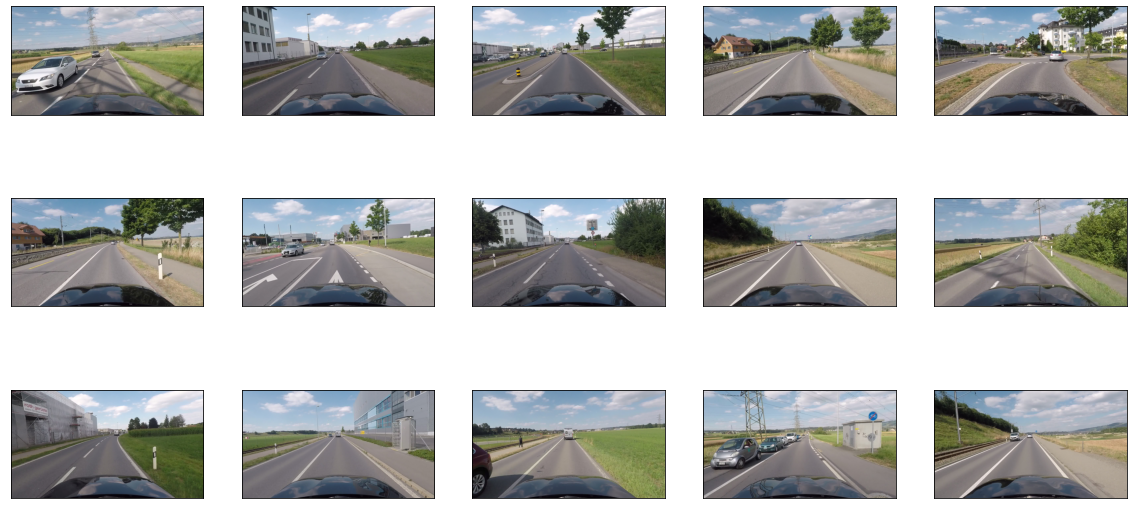

In [ ]:
x = random.sample(range(1,len(train_df)), 15)

plt.figure(1, figsize=(20,10))
for i,value in enumerate(x):
    img = mpimg.imread(train_df.iloc[value]['image_path'])
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

## OpticalFlow

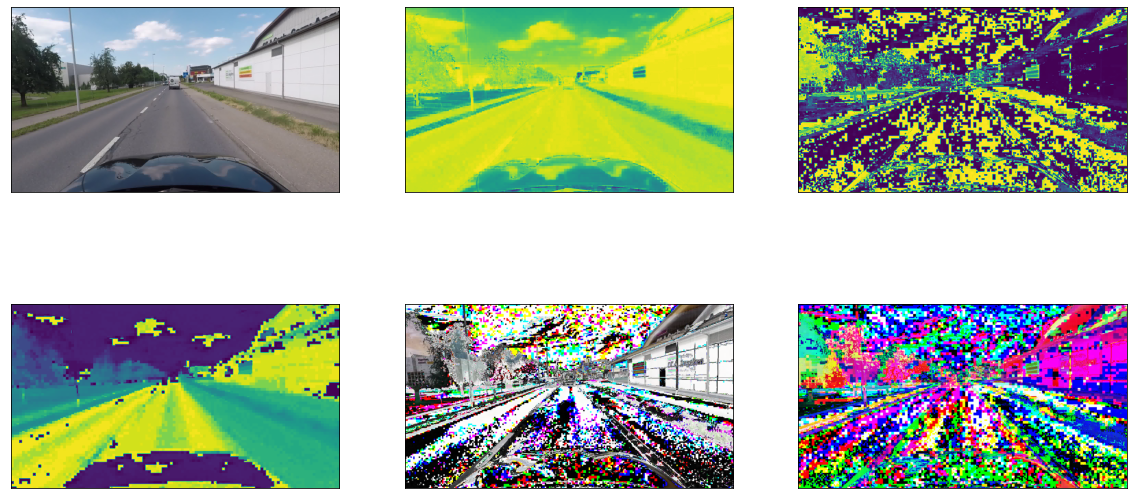

In [ ]:
img1 = mpimg.imread(train_df.iloc[34]['image_path'])
img2 = mpimg.imread(train_df.iloc[23]['image_path'])

rgb_diff = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) - cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
hsv_diff = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV) - cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
sat = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)[:,:,1] - cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,1]
inv_sat = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,1]*-1 
hue = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)[:,:,0]

plt.figure(1, figsize=(20,10))

plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.imshow(img2)

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(inv_sat)

plt.subplot(2,3,3)
plt.xticks([])
plt.yticks([])
plt.imshow(sat)

plt.subplot(2,3,4)
plt.xticks([])
plt.yticks([])
plt.imshow(hue)

plt.subplot(2,3,5)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)

plt.subplot(2,3,6)
plt.xticks([])
plt.yticks([])
plt.imshow(hsv_diff)

In [ ]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros(image_current.shape)
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)    

    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


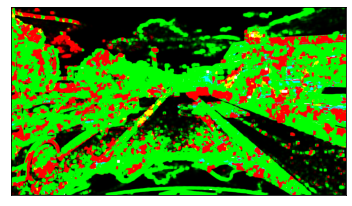

In [ ]:
img1 = mpimg.imread(train_df.iloc[0]['image_path'])
img2 = mpimg.imread(train_df.iloc[1]['image_path'])

rgb_diff = opticalFlowDense(img1,img2)
plt.xticks([])
plt.yticks([])
plt.imshow(rgb_diff)

In [ ]:
def crop_image(image, scale):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (66, 220, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (66, 220, 3) if not done so already from perspective transform
    """
    # Crop out sky (top 130px) and the hood of the car (bottom 270px) 
    image_cropped = image[130:370,:] # -> (240, 640, 3)
    
    height = int(240*scale)
    width = int(640*scale)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [ ]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [ ]:
def preprocess_image_valid_from_path(image_path, scale_factor=0.5):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = crop_image(img, scale_factor)
    return img

In [ ]:
def preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)
    # img = crop_image(img, scale_factor)
    return img

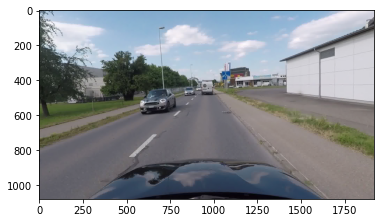

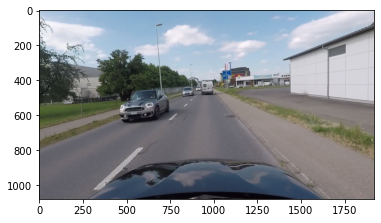

In [ ]:
img = preprocess_image_from_path(train_df.iloc[40]['image_path'])
img_next = preprocess_image_from_path(train_df.iloc[41]['image_path'])

plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img_next)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


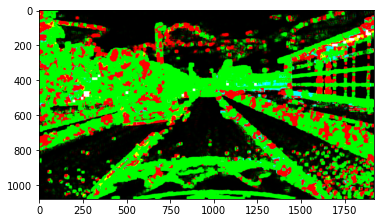

In [ ]:
rgb_flow = opticalFlowDense(img,img_next)
plt.figure()
plt.imshow(rgb_flow)

### Extracting Optical Flow

In [ ]:
output_dir = '/content/drive/MyDrive/Colab/opticalFlow_images/train'
label_out = '/content/drive/MyDrive/Colab/opticalFlow_images/' + 'train_label' + '_pred.txt'
def generate_training_data(data, batch_size = 2, scale_factor = 0.5):
    list_item = []

    i=0
    with open(label_out, 'w') as f:
        while i < len(data)-1:
            speed1 = data.iloc[i]['canSpeedNorm']
            speed2 = data.iloc[i+1]['canSpeedNorm']
        
            img1 = preprocess_image_from_path(data.iloc[i]['image_path'],scale_factor)
            img2 = preprocess_image_from_path(data.iloc[i+1]['image_path'],scale_factor)
            
            rgb_diff = opticalFlowDense(img1, img2)
            rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
            rgb_diff = np.moveaxis(rgb_diff, 3, 1)
            avg_speed = np.mean([speed1,speed2])
            rgb_diff = torch.from_numpy(rgb_diff)
            # list_item.append((rgb_diff, avg_speed))

            of_f_name = output_dir + '/' + f'{i}.npy' 
            np.save(of_f_name, rgb_diff.cpu())

            f.write(str(avg_speed))
            f.write('\n')
            # return rgb_diff, avg_speed

            i += 1
    return

In [ ]:
output_dir_2 = '/content/drive/MyDrive/Colab/opticalFlow_images/valid'
label_out_2 = '/content/drive/MyDrive/Colab/opticalFlow_images/' + 'valid_label' + '_pred.txt'
def generate_validation_data(data, batch_size = 2, scale_factor = 0.5):
    list_item = []

    i=0
    with open(label_out_2, 'w') as f:
        while i < len(data)-1:
            speed1 = data.iloc[i]['canSpeedNorm']
            speed2 = data.iloc[i+1]['canSpeedNorm']
        
            img1 = preprocess_image_valid_from_path(data.iloc[i]['image_path'],scale_factor)
            img2 = preprocess_image_valid_from_path(data.iloc[i+1]['image_path'],scale_factor)
            
            rgb_diff = opticalFlowDense(img1, img2)
            rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
            rgb_diff = np.moveaxis(rgb_diff, 3, 1)
            avg_speed = np.mean([speed1,speed2])
            rgb_diff = torch.from_numpy(rgb_diff)
            # list_item.append((rgb_diff, avg_speed))
            # return rgb_diff, avg_speed

            of_f_name = output_dir_2 + '/' + f'{i}.npy' 
            np.save(of_f_name, rgb_diff.cpu())

            f.write(str(avg_speed))
            f.write('\n')

            i += 1

    return 

In [ ]:
# valid_generator = generate_validation_data(val_df)

In [ ]:
# train_generator = generate_training_data(train_df)

### Getting Optical Flow Data

In [ ]:
# directory with the optical flow images
train_of_dir = '/content/drive/MyDrive/Colab/opticalFlow_images/train'
valid_of_dir = '/content/drive/MyDrive/Colab/opticalFlow_images/valid'

# labels as txt file
labels_train = '/content/drive/MyDrive/Colab/opticalFlow_images/train_label_pred.txt'
labels_valid = '/content/drive/MyDrive/Colab/opticalFlow_images/valid_label_pred.txt'

In [ ]:
## Data Augmentation:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.Resize(256)
])

In [ ]:
class OFDataset(Dataset):
    def __init__(self, of_dir, label_f, transform=None):
        self.len = len(list(Path(of_dir).glob('*.npy')))
        self.of_dir = of_dir
        self.label_file = open(label_f).readlines()
        self.transform = transform
        
    def __len__(self): return self.len

    def __getitem__(self, idx):
        of_array = np.load(Path(self.of_dir)/f'{idx}.npy')
        of_tensor = torch.squeeze(torch.Tensor(of_array))
        label = float(self.label_file[idx].split()[0])
        if self.transform:
            of_tensor = self.transform(of_tensor)
        return [of_tensor, label]

In [ ]:
train_ds = OFDataset(train_of_dir, labels_train)
valid_ds = OFDataset(valid_of_dir, labels_valid)

In [ ]:
image, label = train_ds[2188]
print(label)
print(type(label))
print(image.shape)
print(image.dtype)
print(type(image))

0.7721313946157088
<class 'float'>
torch.Size([3, 1080, 1920])
torch.float32
<class 'torch.Tensor'>


In [ ]:
print(len(valid_ds), len(train_ds))

606 2389


In [ ]:
cpu_cores = multiprocessing.cpu_count()
cpu_cores

4

In [ ]:
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=cpu_cores, pin_memory=True)
test_dataloader = DataLoader(valid_ds, batch_size=4, num_workers=cpu_cores, pin_memory=True)

In [ ]:
# check if cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

'cuda'

# Model

In [ ]:
v = 0     # model version
in_c = 3  # number of input channels
num_c = 1 # number of classes to predict

In [ ]:
model = EfficientNet.from_pretrained(f'efficientnet-b{v}', in_channels=in_c, num_classes=num_c)
model.to(device);

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
!cp /content/drive/MyDrive/Colab/pytorchtools.py /content/
from pytorchtools import EarlyStopping

In [ ]:
patience = 10
epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4

# loss function
criterion = nn.MSELoss()

# Set up cutom optimizer with weight decay
opt = optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
# Set up one-cycle learning rate scheduler
# sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_dataloader) )

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
FILEPATH = '/content/drive/MyDrive/Colab/model.pth'
val_per_epoch = []
train_per_epoch = []
torch.cuda.empty_cache()

In [ ]:
PATH = '/content/drive/MyDrive/Colab/checkpoint.pt'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [ ]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in tqdm(train_dataloader):
        sample, label = batch
        sample = sample.to(device)
        # sample = torch.squeeze(sample)
        label = label.clone().detach().float().to(device)
        label = label.view(-1, 1)
        pred = model(sample)
        loss = criterion(pred, label)
        train_losses.append(loss)
        loss.backward()

        # Gradient clipping
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        opt.step()
        opt.zero_grad()

        # # Record & update learning rate
        # lrs.append(get_lr(opt))
        # sched.step()

    train_loss = sum(train_losses)/len(train_losses) 
    train_per_epoch.append(train_loss.cpu().detach().numpy())

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            sample, label = batch
            sample = sample.to(device)
            # sample = torch.squeeze(sample)
            label = label.clone().detach().float().to(device)
            label = label.view(-1, 1)
            pred = model(sample)
            loss = criterion(pred, label)
            val_losses.append(loss)

        val_loss = sum(val_losses)/len(val_losses)    
        
        # Early_stopping:
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
  
        val_per_epoch.append(val_loss.cpu())
        print(f'Epoch[{epoch+1}/{epochs}]: Validation_loss=>{val_loss}, Training_loss=>{train_loss}')

torch.save(model.state_dict(), FILEPATH)

  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Epoch[1/10]: Validation_loss=>0.007328215520828962, Training_loss=>0.007049511186778545


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.005521).  Saving model ...
Epoch[2/10]: Validation_loss=>0.005521007813513279, Training_loss=>0.003711627097800374


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 10
Epoch[3/10]: Validation_loss=>0.009500047191977501, Training_loss=>0.0030884372536092997


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 10
Epoch[4/10]: Validation_loss=>0.010506843216717243, Training_loss=>0.002749265870079398


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Validation loss decreased (0.005521 --> 0.004270).  Saving model ...
Epoch[5/10]: Validation_loss=>0.004269904922693968, Training_loss=>0.0028063803911209106


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 10
Epoch[6/10]: Validation_loss=>0.007067947182804346, Training_loss=>0.002413118025287986


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Validation loss decreased (0.004270 --> 0.004073).  Saving model ...
Epoch[7/10]: Validation_loss=>0.004073087126016617, Training_loss=>0.0025049687828868628


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 10
Epoch[8/10]: Validation_loss=>0.005977889988571405, Training_loss=>0.0026247401256114244


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 10
Epoch[9/10]: Validation_loss=>0.007009241264313459, Training_loss=>0.002230764599516988


  0%|          | 0/1195 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

Validation loss decreased (0.004073 --> 0.003101).  Saving model ...
Epoch[10/10]: Validation_loss=>0.0031006522476673126, Training_loss=>0.0023475922644138336


In [ ]:
plt.plot(train_per_epoch, label='Training')
plt.plot(val_per_epoch, label='Validation')
plt.legend()
plt.title('Mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.savefig("/content/drive/MyDrive/Colab/loss_curve.jpg")
plt.show()

In [ ]:
PATH = '/content/drive/MyDrive/Colab/model.pth'
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

# Inference

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab/Emmen_27.xlsx')
data = data[['cameraRight', 'canSpeed']]
data['image_path'] = data['cameraRight'].apply(lambda x: '/content/drive/MyDrive/Colab/Emmen_27_images/images'+'/'+str(int((x[-12:].split('.')[0].split('g')[1]))) + '.jpg')

In [ ]:
# mormalize the canSpeed data
scaler = MinMaxScaler()
speed = np.array(data['canSpeed'])
speedNorm = scaler.fit_transform(speed.reshape(-1, 1))
speedNorm = speedNorm.flatten()
data['canSpeedNorm'] = speedNorm
data

,cameraRight,canSpeed,image_path,canSpeedNorm
0,Emmen/go_pro_1/image/27/img00001.jpg,8.344213,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.523057
1,Emmen/go_pro_1/image/27/img00002.jpg,8.388402,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.525827
2,Emmen/go_pro_1/image/27/img00003.jpg,8.439585,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.529036
3,Emmen/go_pro_1/image/27/img00004.jpg,8.509177,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.533398
4,Emmen/go_pro_1/image/27/img00005.jpg,8.549098,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.535900
...,...,...,...,...
2992,Emmen/go_pro_1/image/27/img02993.jpg,13.733794,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.860903
2993,Emmen/go_pro_1/image/27/img02994.jpg,13.754538,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.862203
2994,Emmen/go_pro_1/image/27/img02995.jpg,13.734381,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.860940
2995,Emmen/go_pro_1/image/27/img02996.jpg,13.763111,/content/drive/MyDrive/Colab/Emmen_27_images/i...,0.862741


In [ ]:
def opticalFlowOverlay(image_current, image_next):
    """
    input: image_currentdef preprocess_image_from_path(image_path, scale_factor=0.5, bright_factor=1):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)
    img = crop_image(img, scale_factor)
    return img, image_next (RGB images)
    output: mask
    """
    feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.1,
                       minDistance = 7,
                       blockSize = 5 )
    lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    
    image_current_saved = np.copy(image_current)
    image_next_saved = np.copy(image_next)
    
    image_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    image_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    # Finds edges in an image using the [Canny86] algorithm.
    p0 = cv2.goodFeaturesToTrack(image_current, mask = None, **feature_params)

    p1, st, err = cv2.calcOpticalFlowPyrLK(image_current, image_next, p0, None, **lk_params)


    color = np.random.randint(0, 255, (100, 3))

    mask = np.zeros_like(image_current)

    # Select good points
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel() # flatten
        c, d = old.ravel()
        mask = cv2.arrowedLine(mask, (a,b), (c, d), color[i%100].tolist(), 2, 8)
        
        image_next = cv2.circle(image_next_saved, (a, b), 1, color[i%100].tolist(), -1)
        image_next_fg = cv2.bitwise_and(image_next, image_next, mask = mask)
        
    dst = cv2.add(image_next, image_next_fg)
    return dst

In [ ]:
actual_speed = []
predicted_speed = []
preprocess = T.Resize(512)
model.eval()
for i in range(len(data)-1):
    y1 = data.iloc[i]['canSpeedNorm']
    y2 = data.iloc[i+1]['canSpeedNorm']
    
    x1 = preprocess_image_from_path(data.iloc[i]['image_path'])
    x2 = preprocess_image_from_path(data.iloc[i+1]['image_path'])
    
    # img1 = cv2.cvtColor(cv2.imread(data.iloc[i]['image_path']), cv2.COLOR_BGR2RGB)
    # img2 = cv2.cvtColor(cv2.imread(data.iloc[i+1]['image_path']), cv2.COLOR_BGR2RGB)
        
    rgb_diff = opticalFlowDense(x1, x2)
    rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
    rgb_diff = np.moveaxis(rgb_diff, 3, 1)
    rgb_diff = torch.from_numpy(rgb_diff).to(device)
    avg_speed = np.array([[np.mean([y1,y2])]])
    
    rgb_diff = rgb_diff.to(device)
    rgb_diff = preprocess(rgb_diff)
    # print(rgb_diff.shape)
    prediction = model(rgb_diff)
    prediction = prediction.cpu().detach().numpy()
    predicted_speed.append(prediction[0][0])
    error = abs(prediction - y2)
    actual_speed.append(y2)
    truth = y2
    
    # predict_path = os.path.join('/content/drive/MyDrive/Colab/Emmen_27_images', str(i) + '.jpg')
    
    # dst = np.copy(img2)
    
    # dst = opticalFlowOverlay(img1, img2) # This is a sparse optical flow overlay
    
    # # to write new image via openCV
    # offset = 50
    # FONT_SIZE = 1
    # THICKNESS = 2
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(dst,'pred: ' + str(prediction[0][0])[:5],(10,offset), font, FONT_SIZE,(255,250,40), THICKNESS,cv2.LINE_AA)
    # cv2.putText(dst,'truth: ' + str(y2)[:5],(10,offset+50), font, FONT_SIZE,(35,255,70), THICKNESS,cv2.LINE_AA)
    # cv2.putText(dst, 'error: ' + str(error[0][0])[:5], (10, offset+100),font, FONT_SIZE, (255, 120, 80), THICKNESS, cv2.LINE_AA)
    
    # # convert back to BGR for writing
    # dst = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    # cv2.imwrite(predict_path, dst)
    
print('done!')

done!


In [ ]:
print(predicted_speed[0])
print(actual_speed[0])
plt.plot(actual_speed, label='Actual Speed')
plt.plot(predicted_speed, label='Predicted Speed')
plt.legend()
plt.savefig("/content/drive/MyDrive/Colab/actual_vs_predicted.jpg")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(actual_speed, predicted_speed)

In [ ]:
# predicted_speed

In [ ]:
pred = scaler.inverse_transform([predicted_speed])
pred = pred.flatten()
pred.shape

(2996,)

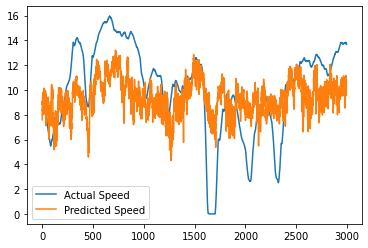

In [ ]:
plt.plot(list(data['canSpeed']), label='Actual Speed')
plt.plot(pred, label='Predicted Speed')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(list(data['canSpeed'])[1:], pred)

9.694080617824754

In [ ]:
# from moviepy.editor import VideoFileClip
# from moviepy.editor import ImageSequenceClip
# import glob
# import os

# folder_path = '/content/drive/MyDrive/Colab/Emmen_27_images/'
# images = [folder_path + str(i+1) + '.jpg' for i in range(0, len(os.listdir(folder_path))-2)]
# clip = ImageSequenceClip(images, fps=60)
# clip.write_videofile("/content/drive/MyDrive/Colab/predicted_speed_fast.mp4", fps=60)
# print('done!')

## Video 1

In [ ]:
path = '/content/drive/Shareddrives/MACHINEL/data/video_4/'
image_list = os.listdir('/content/drive/Shareddrives/MACHINEL/data/video_4')
image_list = sorted(image_list)
test_data = pd.DataFrame({'image' : image_list})
test_data['image_path'] = test_data['image'].apply(lambda x: path + '/' + x)
len(test_data)

10

In [ ]:
# actual_speed = []
predicted_speed = []
model.eval()
for i in range(len(test_data)-1):
    x1 = preprocess_image_from_path(test_data.iloc[i]['image_path'])
    x2 = preprocess_image_from_path(test_data.iloc[i+1]['image_path'])

    rgb_diff = opticalFlowDense(x1, x2)
    rgb_diff = rgb_diff.reshape(1, rgb_diff.shape[0], rgb_diff.shape[1], rgb_diff.shape[2])
    rgb_diff = np.moveaxis(rgb_diff, 3, 1)
    rgb_diff = torch.from_numpy(rgb_diff).to(device)

    prediction = model(rgb_diff)
    prediction = prediction.cpu().detach().numpy()
    predicted_speed.append(prediction[0][0])

In [ ]:
predicted_speed

[4.5449014,
 3.1394446,
 4.667377,
 5.0852957,
 4.9061165,
 6.6539702,
 5.655808,
 5.1486754,
 5.1885934]

In [ ]:
predicted_speed

[3.629359,
 1.8699373,
 4.00354,
 3.4422095,
 4.0554643,
 6.754582,
 4.6673255,
 4.39149,
 3.996637]